<a href="https://colab.research.google.com/github/Sanakhalid26/SkindiseasedetectionusingDermnet/blob/main/Improved_work_DERMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os

# Paths to datasets
TRAIN_DIR = '/content/drive/MyDrive/archive/train'
VALID_DIR = '/content/drive/MyDrive/archive/test'

# Function to count images in each class
def count_images_per_class(dataset_dir):
    class_counts = {}
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):  # Check if it's a directory
            num_images = len([img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])
            class_counts[class_name] = num_images
    return class_counts

# Count images in training and validation datasets
train_class_counts = count_images_per_class(TRAIN_DIR)
val_class_counts = count_images_per_class(VALID_DIR)

# Display the counts
print("Training Dataset Class Counts:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} images")


Training Dataset Class Counts:
Vasculitis Photos: 416 images
Poison Ivy Photos and other Contact Dermatitis: 260 images
Melanoma Skin Cancer Nevi and Moles: 463 images
Light Diseases and Disorders of Pigmentation: 568 images
Eczema Photos: 1235 images
Atopic Dermatitis Photos: 489 images
Acne and Rosacea Photos: 840 images

Validation Dataset Class Counts:
Acne and Rosacea Photos: 312 images
Atopic Dermatitis Photos: 120 images
Eczema Photos: 309 images
Light Diseases and Disorders of Pigmentation: 143 images
Melanoma Skin Cancer Nevi and Moles: 116 images
Poison Ivy Photos and other Contact Dermatitis: 64 images
Vasculitis Photos: 105 images


In [ ]:
import os
import shutil
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
TRAIN_DIR = '/content/drive/MyDrive/archive/train'
VALID_DIR = '/content/drive/MyDrive/archive/test'

# Oversampled Dataset Class
class OversampledDataset(Dataset):
    def __init__(self, image_generator):
        self.image_generator = image_generator
        self.image_paths = image_generator.filepaths
        self.labels = image_generator.classes
        self.classes = image_generator.class_indices

        # Compute class counts and find the maximum
        self.class_counts = np.bincount(self.labels)
        self.max_count = self.class_counts.max()

        # Oversample by duplicating paths and labels for minority classes
        self.oversampled_paths = []
        self.oversampled_labels = []

        for class_idx in range(len(self.class_counts)):
            class_paths = [self.image_paths[i] for i in range(len(self.labels)) if self.labels[i] == class_idx]
            oversample_factor = self.max_count // len(class_paths)  # Number of times to duplicate
            self.oversampled_paths.extend(class_paths * oversample_factor)
            self.oversampled_labels.extend([class_idx] * len(class_paths) * oversample_factor)

        print(f"Original class counts: {self.class_counts}")
        print(f"Oversampled dataset size: {len(self.oversampled_paths)}")

    def __len__(self):
        return len(self.oversampled_paths)

    def __getitem__(self, idx):
        img_path = self.oversampled_paths[idx]
        label = self.oversampled_labels[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1))  # Convert to CHW format
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Constants
image_size = 128
batch_size = 16

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
training_set = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_set = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create Datasets and Data Loaders
train_dataset = OversampledDataset(training_set)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Custom Dataset for Validation
class CustomDataset(Dataset):
    def __init__(self, image_generator):
        self.image_paths = image_generator.filepaths
        self.labels = image_generator.classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1))  # Convert to CHW format
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

val_dataset = CustomDataset(validation_set)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify Oversampling
oversampled_labels = [label for _, label in train_dataset]
print(f"Oversampled class distribution: {np.bincount(oversampled_labels)}")


Found 4271 images belonging to 7 classes.
Found 1169 images belonging to 7 classes.
Original class counts: [ 840  489 1235  568  463  260  416]
Oversampled dataset size: 6987
Oversampled class distribution: [ 840  978 1235 1136  926 1040  832]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Class Names
print("Classes:", training_set.class_indices)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

Classes: {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Light Diseases and Disorders of Pigmentation': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Vasculitis Photos': 6}


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1558s 55s/step - accuracy: 0.1839 - loss: 2.0989 - val_accuracy: 0.1956 - val_loss: 1.9169
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 825ms/step - accuracy: 0.1968 - loss: 1.9903 - val_accuracy: 0.2039 - val_loss: 1.9143
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 845ms/step - accuracy: 0.2146 - loss: 1.9231 - val_accuracy: 0.1896 - val_loss: 1.9255
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - accuracy: 0.2151 - loss: 1.9352 - val_accuracy: 0.2619 - val_loss: 1.9130
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 777ms/step - accuracy: 0.2357 - loss: 1.9131 - val_accuracy: 0.2393 - val_loss: 1.9166
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 837ms/step - accuracy: 0.2457 - loss: 1.9140 - val_accuracy: 0.2957 - val_loss: 1.8953
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 861ms/step - accuracy: 0.2466 - loss: 1.9032 - val_accuracy: 0.3078 - val_loss: 1.8871
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 863ms/step - accuracy: 0.2760 - loss: 1.8869 - val_accuracy: 0.299

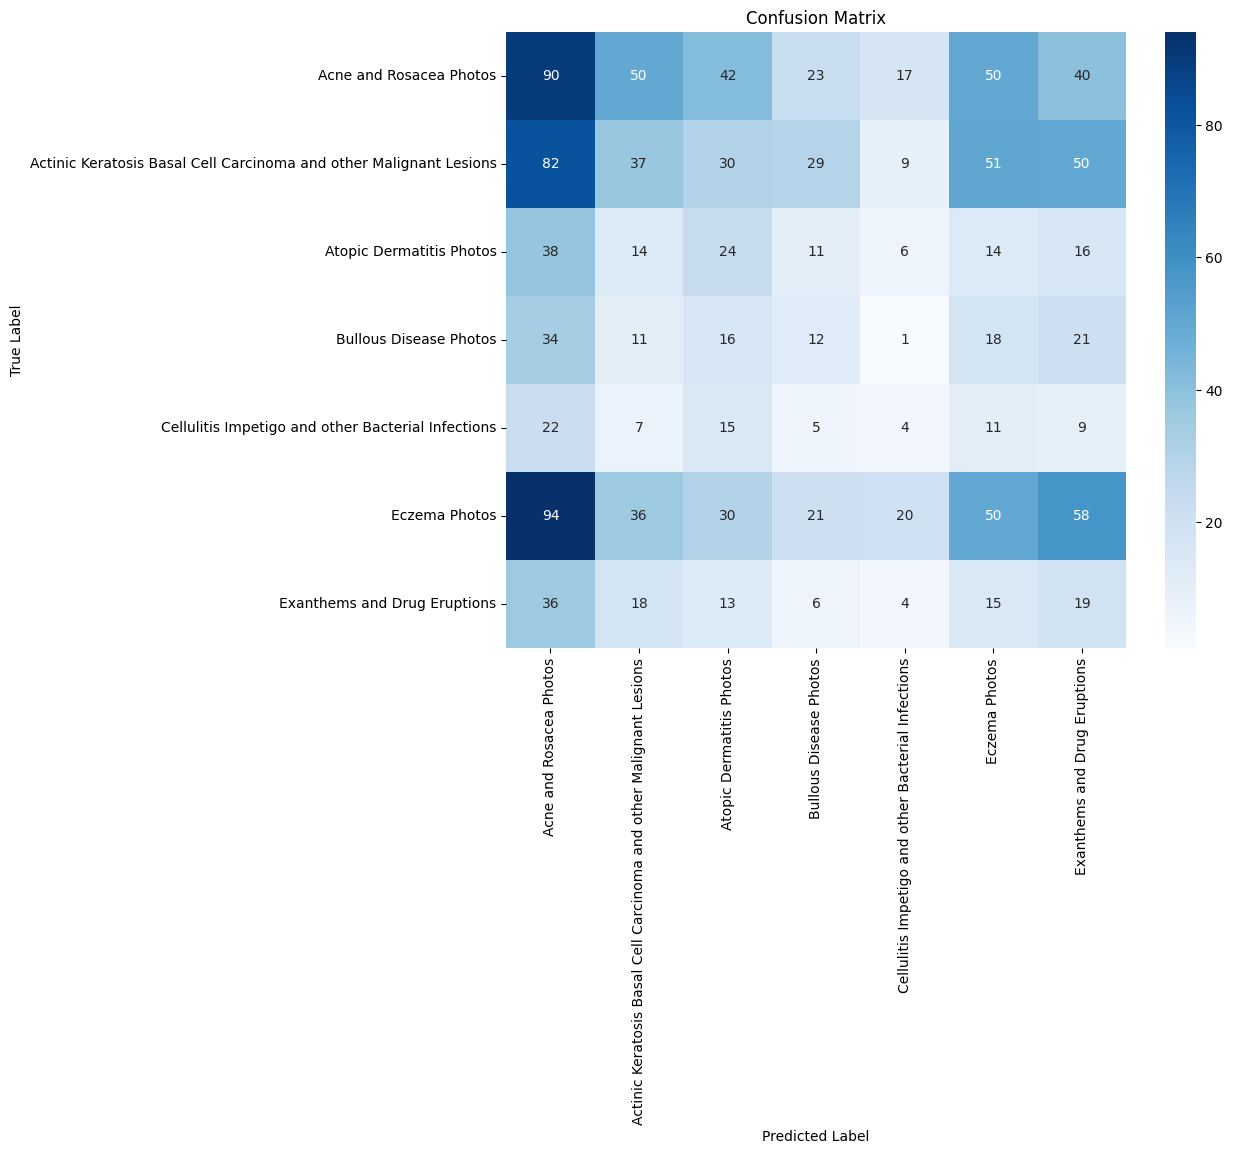

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.23      0.29      0.25       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.21      0.13      0.16       288
                                          Atopic Dermatitis Photos       0.14      0.20      0.16       123
                                            Bullous Disease Photos       0.11      0.11      0.11       113
                Cellulitis Impetigo and other Bacterial Infections       0.07      0.05      0.06        73
                                                     Eczema Photos       0.24      0.16      0.19       309
                                      Exanthems and Drug Eruptions       0.09      0.17      0.12       111

                                                          accuracy                           0.18      1329
   

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image and batch size
IMAGE_SIZE = 224  # VGG16 input size
BATCH_SIZE = 32

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights
)

# Save the model
model.save('vgg16_filtered_7classes.keras')

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

# Generate Predictions
val_generator.reset()  # Reset generator to match labels and predictions
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)  # Predicted class indices
y_true = val_generator.classes           # True labels

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,567,943 (28.87 MB)

 Trainable params: 896,583 (3.42 MB)

 Non-trainable params: 6,671,360 (25.45 MB)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1467 - loss: 2.6604 - val_accuracy: 0.1196 - val_loss: 2.2845
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 853ms/step - accuracy: 0.2991 - loss: 2.1468 - val_accuracy: 0.1896 - val_loss: 2.0548
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 826ms/step - accuracy: 0.3489 - loss: 1.9123 - val_accuracy: 0.2777 - val_loss: 1.9009
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 915ms/step - accuracy: 0.3725 - loss: 1.8578 - val_accuracy: 0.3175 - val_loss: 1.8249
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 779ms/step - accuracy: 0.4067 - loss: 1.6582 - val_accuracy: 0.3567 - val_loss: 1.7467
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 755ms/step - accuracy: 0.4308 - loss: 1.6213 - val_accuracy: 0.3837 - val_loss: 1.6950
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 802ms/step - accuracy: 0.4692 - loss: 1.4775 - val_accuracy: 0.4048 - val_loss: 1.6543
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - accuracy: 0.4846 - loss: 1.4857 - val_accurac

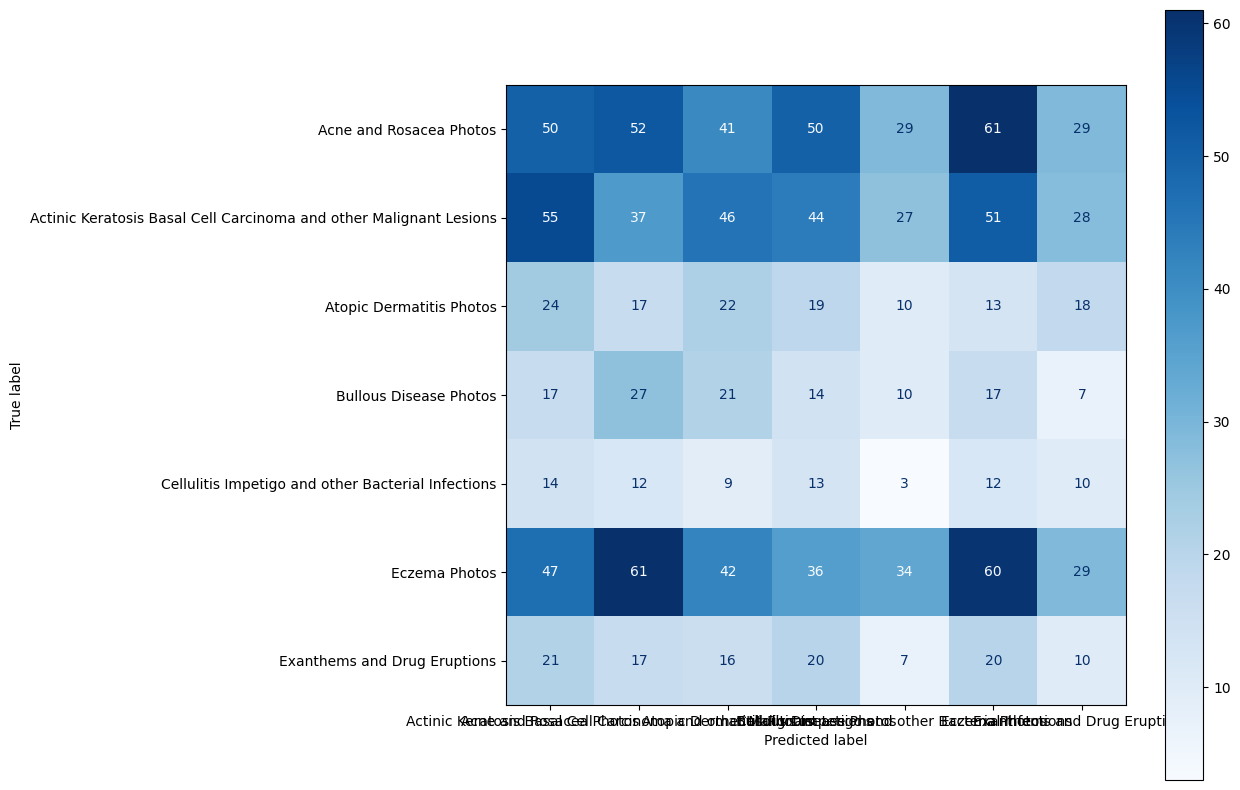

In [ ]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Constants
BATCH_SIZE = 32
EPOCHS = 50
NUMBER_OF_CLASSES = 7  # First 7 classes

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

IMAGE_SIZE = 224
LEARNING_RATE = 0.0001

# Load DenseNet121 as the base model
base_model = DenseNet121(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet')
base_model.trainable = True  # Fine-tuning enabled

# Freeze all but the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),           # Global pooling to reduce dimensions
    Dense(512, activation='relu'),      # Dense layer with ReLU activation
    BatchNormalization(),               # Batch normalization for stability
    Dropout(0.3),                       # Dropout for regularization
    Dense(NUMBER_OF_CLASSES, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights
)

# Save the trained model
model.save('/content/drive/MyDrive/archive/densenet_filtered_7classes.keras')

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


# Evaluate model
val_true = val_generator.classes
val_pred_raw = model.predict(val_generator)
val_pred = np.argmax(val_pred_raw, axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(val_true, val_pred, target_names=list(val_generator.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(val_true, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()





In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = 299  # Xception requires a minimum input size of 299x299
LEARNING_RATE = 0.0001
NUMBER_OF_CLASSES = 7  # First 7 classes


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Now uses IMAGE_SIZE = 299
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Now uses IMAGE_SIZE = 299
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load Xception as the base model
base_model = Xception(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet')
base_model.trainable = True  # Fine-tuning enabled

# Freeze all but the last 20 layers of Xception
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),           # Global pooling to reduce dimensions
    Dense(512, activation='relu'),      # Dense layer with ReLU activation
    BatchNormalization(),               # Batch normalization for stability
    Dropout(0.3),                       # Dropout for regularization
    Dense(NUMBER_OF_CLASSES, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()


Found 821 images belonging to 7 classes.
Found 1329 images belonging to 7 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,916,207 (83.60 MB)

 Trainable params: 8,380,079 (31.97 MB)

 Non-trainable params: 13,536,128 (51.64 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust based on needs
    class_weight=class_weights
)

# Save the trained model
model.save('/content/drive/MyDrive/archive/xception_filtered_7classes.keras')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.2037 - loss: 2.6059 - val_accuracy: 0.3732 - val_loss: 1.7907
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4184 - loss: 1.6459 - val_accuracy: 0.4078 - val_loss: 1.7305
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4997 - loss: 1.3974 - val_accuracy: 0.4409 - val_loss: 1.6784
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5796 - loss: 1.2074 - val_accuracy: 0.4409 - val_loss: 1.6587
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6086 - loss: 1.0829 - val_accuracy: 0.4733 - val_loss: 1.5810
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6692 - loss: 0.8998 - val_accuracy: 0.4868 - val_loss: 1.5386
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7157 - loss: 0.8501 - val_accuracy: 0.4831 - val_loss: 1.5093
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7262 - loss: 0.7235 - val_accuracy: 0.4846 - val_loss: 1.4828
Ep

42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 291ms/step - accuracy: 0.5612 - loss: 2.0947
Validation Accuracy: 0.56
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step
Confusion Matrix:
[[75 65 41 36 17 33 45]
 [76 51 45 24 24 44 24]
 [26 25 18  8 12 24 10]
 [26 18  7 15  8 21 18]
 [17  5  9 11  8 15  8]
 [77 54 40 34 32 34 38]
 [29 22 15 10  9 19  7]]


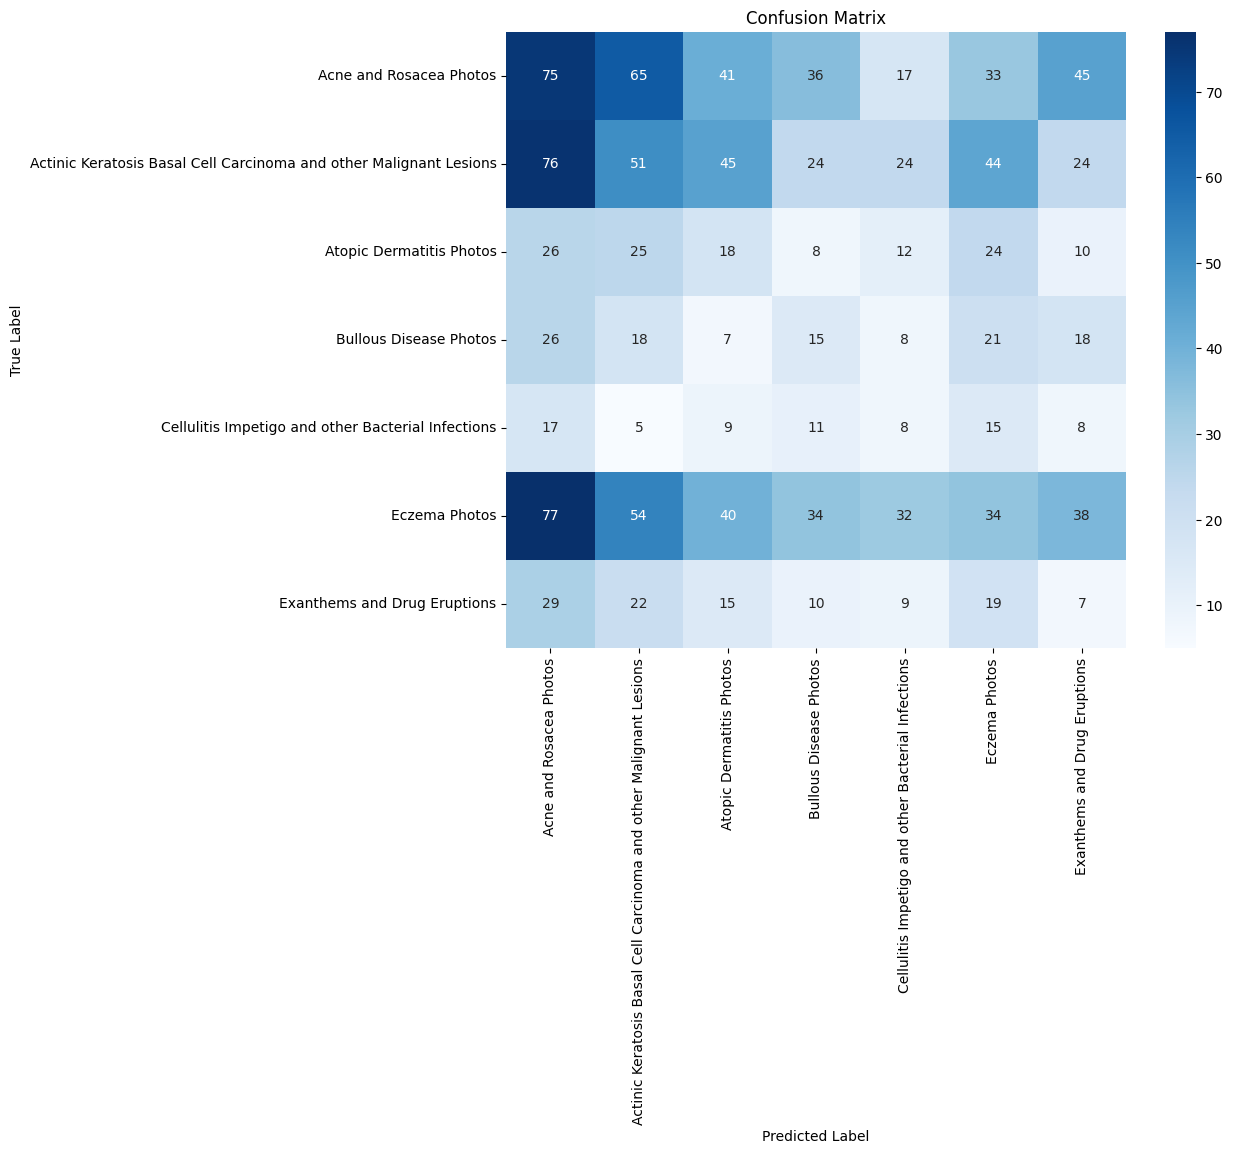

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.23      0.24      0.24       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.21      0.18      0.19       288
                                          Atopic Dermatitis Photos       0.10      0.15      0.12       123
                                            Bullous Disease Photos       0.11      0.13      0.12       113
                Cellulitis Impetigo and other Bacterial Infections       0.07      0.11      0.09        73
                                                     Eczema Photos       0.18      0.11      0.14       309
                                      Exanthems and Drug Eruptions       0.05      0.06      0.05       111

                                                          accuracy                           0.16      1329
   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

# Generate predictions
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)  # Predicted class indices
y_true = val_generator.classes           # True labels

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

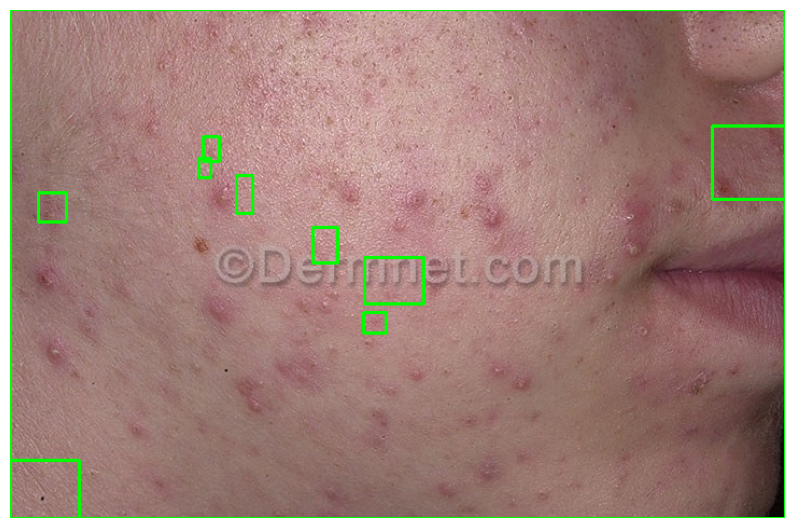

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/07Acne081101.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform selective search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()  # Fast mode, low recall
# ss.switchToSelectiveSearchQuality()  # High quality, slower

rectangles = ss.process()

# Display the image with bounding boxes
for rect in rectangles[:10]:  # Show first 10 proposals
    x, y, w, h = rect
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
Predicted Class: Band_Aid, Confidence: 0.1489


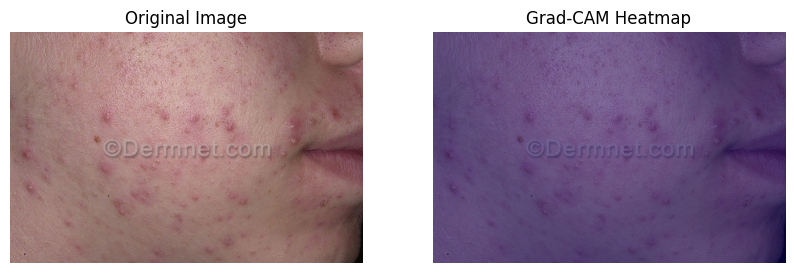

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def grad_cam_vgg16(model, image_path, layer_name='block5_conv3', alpha=0.4):
    """
    Generate a Grad-CAM heatmap for an input image using VGG16.
    Args:
        model: Pre-trained Keras model.
        image_path: Path to the input image.
        layer_name: Name of the convolutional layer for Grad-CAM.
        alpha: Blending factor for overlaying heatmap on the original image.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocessing for VGG16

    # Forward pass through the model to get the prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    print(f"Predicted Class: {decode_predictions(preds, top=1)[0][0][1]}, Confidence: {preds[0][predicted_class]:.4f}")

    # Grad-CAM calculations
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_output)[0]

    if grads is None:
        print(f"Gradients are None for {layer_name}. Trying a different layer...")
        # Try another layer if gradients are None
        return grad_cam_vgg16(model, image_path, layer_name='block4_conv3', alpha=alpha)

    # Pool gradients and apply them to the convolutional output
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Generate the heatmap
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= (np.max(heatmap) + 1e-7)

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize and overlay heatmap
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_colored = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Blend the heatmap with the original image
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)

    # Display the images
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(overlayed_image)
    plt.axis('off')

    plt.show()

# Path to your image
image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/07Acne081101.jpg"

# Load VGG16 model with pre-trained weights (excluding the top layer)
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Generate Grad-CAM heatmap
grad_cam_vgg16(model, image_path, layer_name='block5_conv3')  # Try 'block5_conv3' or 'block4_conv3' if issues arise




# **IMPROVED RESULTS**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet201
from torchvision.transforms import ToTensor, Normalize, Resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define the DenseNet Class
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # Get the pretrained DenseNet201 model
        self.densenet = densenet201(pretrained=True)

        # Dissect the network to access its last convolutional layer
        self.features_conv = self.densenet.features

        # Add global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Get the classifier
        self.classifier = self.densenet.classifier

        # Placeholder for the gradients
        self.gradients = None

    # Hook to capture gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)
        x.requires_grad_(True)

        # Register the hook
        h = x.register_hook(self.activations_hook)



        # Pooling and flattening
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)


# Heatmap Generation
def generate_heatmap(activation_map, original_image_path, output_path):
    img = cv2.imread(original_image_path)
    heatmap = cv2.resize(activation_map, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(output_path, superimposed_img)



# Paths and Data Setup
data_path = '/content/drive/MyDrive/archive/'
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

# Image Size and Classes
image_size = 128
batch_size = 16
num_classes = 7


train_dataset = OversampledDataset(training_set)
val_dataset = CustomDataset(validation_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")


Original class counts: [ 840  489 1235  568  463  260  416]
Oversampled dataset size: 6987


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 87.4MB/s]


Epoch 1/10


100%|██████████| 437/437 [35:43<00:00,  4.91s/it]


Training Loss: 2.4045
Training Accuracy: 54.47%
Validation Loss: 1.0028
Validation Accuracy: 70.15%
Epoch 2/10


100%|██████████| 437/437 [34:31<00:00,  4.74s/it]


Training Loss: 0.4458
Training Accuracy: 85.82%
Validation Loss: 1.0829
Validation Accuracy: 72.20%
Epoch 3/10


100%|██████████| 437/437 [34:41<00:00,  4.76s/it]


Training Loss: 0.2329
Training Accuracy: 92.73%
Validation Loss: 1.1351
Validation Accuracy: 73.57%
Epoch 4/10


100%|██████████| 437/437 [34:57<00:00,  4.80s/it]


Training Loss: 0.1885
Training Accuracy: 94.25%
Validation Loss: 1.1445
Validation Accuracy: 73.99%
Epoch 5/10


100%|██████████| 437/437 [34:38<00:00,  4.76s/it]


Training Loss: 0.1796
Training Accuracy: 94.48%
Validation Loss: 1.2751
Validation Accuracy: 71.34%
Epoch 6/10


100%|██████████| 437/437 [34:24<00:00,  4.72s/it]


Training Loss: 0.1569
Training Accuracy: 95.12%
Validation Loss: 1.2825
Validation Accuracy: 73.57%
Epoch 7/10


100%|██████████| 437/437 [34:39<00:00,  4.76s/it]


Training Loss: 0.1655
Training Accuracy: 94.90%
Validation Loss: 1.1770
Validation Accuracy: 73.65%
Epoch 8/10


100%|██████████| 437/437 [34:54<00:00,  4.79s/it]


Training Loss: 0.1598
Training Accuracy: 94.95%
Validation Loss: 1.1477
Validation Accuracy: 74.34%
Epoch 9/10


 95%|█████████▌| 416/437 [32:50<01:35,  4.56s/it]

In [ ]:
torch.save(model.state_dict(), "modelnew.pth")

In [ ]:
# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./grad_cam_output.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Heatmap Image
generate_heatmap(heatmap, test_image_path, output_path)
print(f"Grad-CAM visualization saved to {output_path}")


In [ ]:
# Display the image
image_path = './grad_cam_output.jpg'
image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for Matplotlib

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.title("Grad-CAM Visualization")
plt.show()

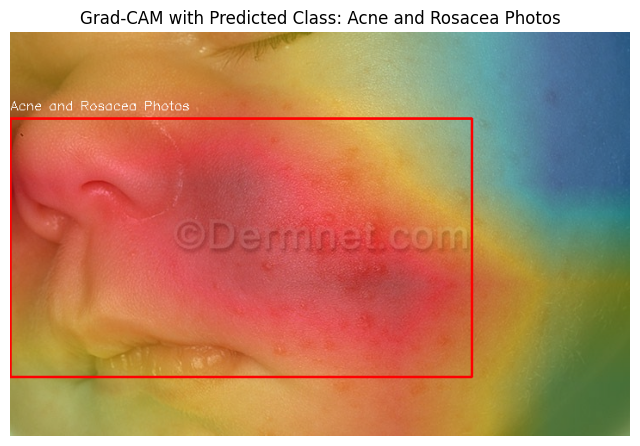

Precise Grad-CAM visualization with bounding boxes and labels saved to ./precise_grad_cam_with_labels.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class Index Mapping
class_idx_to_name = {
    0: 'Acne and Rosacea Photos',
    1: 'Atopic Dermatitis Photos',
    2: 'Eczema Photos',
    3: 'Light Diseases and Disorders of Pigmentation',
    4: 'Melanoma Skin Cancer Nevi and Moles',
    5: 'Poison Ivy Photos and other Contact Dermatitis',
    6: 'Vasculitis Photos'
}

def generate_heatmap_with_precise_boxes_and_labels(heatmap, original_image_path, output_path, predicted_class, threshold=0.8):
    """
    Generates a heatmap, overlays bounding boxes on high-activation regions, and displays the predicted class name.

    Parameters:
    - heatmap: The Grad-CAM heatmap as a numpy array.
    - original_image_path: Path to the original image.
    - output_path: Path to save the final visualization.
    - predicted_class: The predicted class index.
    - threshold: Threshold for determining high-activation regions in the heatmap.
    """
    # Load the original image
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Normalize the heatmap to range [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Reverse the color map to match the original Grad-CAM style
    heatmap_colored = cv2.applyColorMap(255 - heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose the heatmap onto the original image
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    # Threshold the heatmap to find high-activation areas
    _, binary_map = cv2.threshold(heatmap_resized, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours from the binary map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw precise bounding boxes and add class labels
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < 50:  # Ignore very small boxes to avoid noise
            continue
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue bounding box
        label = class_idx_to_name[predicted_class]
        cv2.putText(superimposed_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Save and display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM with Predicted Class: {class_idx_to_name[predicted_class]}")
    plt.savefig(output_path)
    plt.show()

# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./precise_grad_cam_with_labels.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Heatmap with Bounding Boxes and Labels
generate_heatmap_with_precise_boxes_and_labels(heatmap, test_image_path, output_path, class_idx, threshold=0.8)
print(f"Precise Grad-CAM visualization with bounding boxes and labels saved to {output_path}")


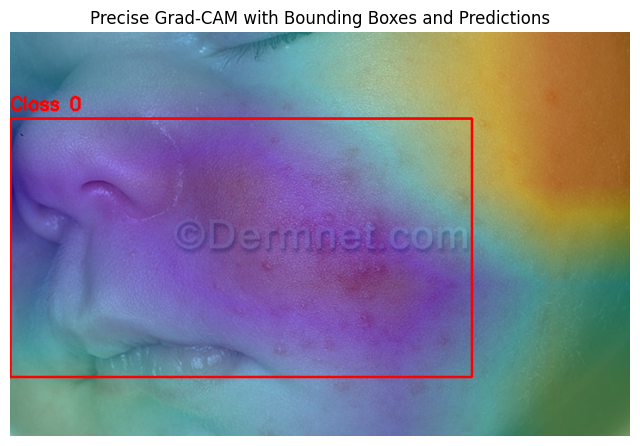

Precise Grad-CAM visualization with bounding boxes and predictions saved to ./precise_grad_cam_with_boxes_and_labels.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap_with_precise_boxes_and_labels(heatmap, original_image_path, output_path, predictions, threshold=0.8):
    """
    Generates a heatmap and overlays bounding boxes on regions with the highest activation, displaying the prediction.

    Parameters:
    - heatmap: The Grad-CAM heatmap as a numpy array.
    - original_image_path: Path to the original image.
    - output_path: Path to save the heatmap with bounding boxes.
    - predictions: The predicted class label for the image.
    - threshold: Threshold for determining high-activation regions in the heatmap.
    """
    # Load the original image
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Normalize the heatmap to range [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Create the heatmap visualization
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    # Threshold the heatmap to find high-activation areas
    _, binary_map = cv2.threshold(heatmap_resized, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours from the binary map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw precise bounding boxes and add predictions
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < 50:  # Ignore very small boxes to avoid noise
            continue
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue bounding box
        cv2.putText(superimposed_img, predictions, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Save and display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Precise Grad-CAM with Bounding Boxes and Predictions")
    plt.savefig(output_path)
    plt.show()


# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./precise_grad_cam_with_boxes_and_labels.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
predicted_label = f"Class {class_idx}"  # Add your class label mapping if needed
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Precise Heatmap with Bounding Boxes
generate_heatmap_with_precise_boxes_and_labels(heatmap, test_image_path, output_path, predicted_label, threshold=0.8)
print(f"Precise Grad-CAM visualization with bounding boxes and predictions saved to {output_path}")


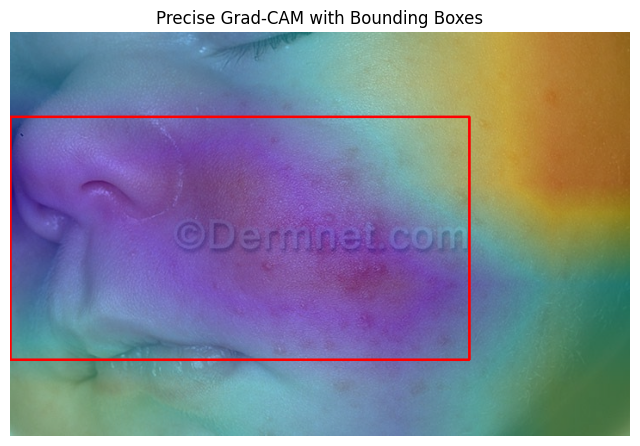

Precise Grad-CAM visualization with bounding boxes saved to ./precise_grad_cam_with_boxes.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap_with_precise_boxes(heatmap, original_image_path, output_path, threshold=0.8):
    """
    Generates a heatmap and overlays precise bounding boxes on regions with the highest activation.

    Parameters:
    - heatmap: The Grad-CAM heatmap as a numpy array.
    - original_image_path: Path to the original image.
    - output_path: Path to save the heatmap with bounding boxes.
    - threshold: Threshold for determining high-activation regions in the heatmap.
    """
    # Load the original image
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Normalize the heatmap to range [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Create the heatmap visualization
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    # Threshold the heatmap to find precise high-activation areas
    _, binary_map = cv2.threshold(heatmap_resized, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours from the binary map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw precise bounding boxes around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < 50:  # Ignore very small boxes to avoid noise
            continue
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue bounding box

    # Save and display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Precise Grad-CAM with Bounding Boxes")
    plt.savefig(output_path)
    plt.show()

# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./precise_grad_cam_with_boxes.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Precise Heatmap with Bounding Boxes
generate_heatmap_with_precise_boxes(heatmap, test_image_path, output_path, threshold=0.8)
print(f"Precise Grad-CAM visualization with bounding boxes saved to {output_path}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Add variables to store training and validation metrics
train_accuracies = []
val_accuracies = []

# Training Loop (updated to save accuracies)
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)  # Save training accuracy
    print(f"Training Loss: {running_loss / len(train_loader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)  # Save validation accuracy
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'Class {i}' for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Epoch 1/10


  7%|▋         | 29/437 [03:04<43:15,  6.36s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Variables to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Updated Training Loop to store metrics
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {train_losses[-1]:.4f}")
    print(f"Training Accuracy: {train_accuracies[-1]:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting Training and Validation Loss/Accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and F1-Score
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)]))


Epoch 1/10


  0%|          | 2/437 [00:20<1:13:05, 10.08s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet201
from torchvision.transforms import ToTensor, Normalize, Resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define the DenseNet Class
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # Get the pretrained DenseNet201 model
        self.densenet = densenet201(pretrained=True)

        # Dissect the network to access its last convolutional layer
        self.features_conv = self.densenet.features

        # Add global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Get the classifier
        self.classifier = self.densenet.classifier

        # Placeholder for the gradients
        self.gradients = None

    # Hook to capture gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)
        x.requires_grad_(True)

        # Register the hook
        h = x.register_hook(self.activations_hook)



        # Pooling and flattening
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)


# Heatmap Generation
def generate_heatmap(activation_map, original_image_path, output_path):
    img = cv2.imread(original_image_path)
    heatmap = cv2.resize(activation_map, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(output_path, superimposed_img)


# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_generator):
        self.image_generator = image_generator
        self.image_paths = image_generator.filepaths
        self.labels = image_generator.classes
        self.classes = image_generator.class_indices

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1))  # Convert to CHW format
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Paths and Data Setup
data_path = '/content/drive/MyDrive/archive/'
train_dir = os.path.join(data_path, 'train_downsampled')

# Image Size and Classes
image_size = 128
batch_size = 16
num_classes = 7

# Image Generators for Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training and Validation Sets
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

train_dataset = CustomDataset(training_set)
val_dataset = CustomDataset(validation_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")


Found 660 images belonging to 7 classes.
Found 161 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


100%|██████████| 42/42 [03:16<00:00,  4.67s/it]


Training Loss: 7.3342
Training Accuracy: 13.64%
Validation Loss: 6.1879
Validation Accuracy: 17.39%
Epoch 2/10


100%|██████████| 42/42 [03:11<00:00,  4.56s/it]


Training Loss: 2.2478
Training Accuracy: 62.73%
Validation Loss: 5.0612
Validation Accuracy: 24.22%
Epoch 3/10


100%|██████████| 42/42 [03:26<00:00,  4.91s/it]


Training Loss: 0.6345
Training Accuracy: 88.33%
Validation Loss: 4.8073
Validation Accuracy: 29.81%
Epoch 4/10


100%|██████████| 42/42 [03:20<00:00,  4.78s/it]


Training Loss: 0.2464
Training Accuracy: 95.61%
Validation Loss: 4.5964
Validation Accuracy: 27.95%
Epoch 5/10


100%|██████████| 42/42 [03:18<00:00,  4.73s/it]


Training Loss: 0.2300
Training Accuracy: 96.82%
Validation Loss: 4.8923
Validation Accuracy: 34.16%
Epoch 6/10


100%|██████████| 42/42 [03:15<00:00,  4.66s/it]


Training Loss: 0.2806
Training Accuracy: 96.36%
Validation Loss: 4.9955
Validation Accuracy: 29.81%
Epoch 7/10


100%|██████████| 42/42 [03:14<00:00,  4.64s/it]


Training Loss: 0.1571
Training Accuracy: 96.97%
Validation Loss: 5.3608
Validation Accuracy: 29.81%
Epoch 8/10


100%|██████████| 42/42 [03:11<00:00,  4.56s/it]


Training Loss: 0.1223
Training Accuracy: 97.73%
Validation Loss: 4.6924
Validation Accuracy: 29.19%
Epoch 9/10


100%|██████████| 42/42 [03:14<00:00,  4.63s/it]


Training Loss: 0.1510
Training Accuracy: 97.58%
Validation Loss: 4.6010
Validation Accuracy: 34.16%
Epoch 10/10


100%|██████████| 42/42 [03:12<00:00,  4.58s/it]


Training Loss: 0.0759
Training Accuracy: 97.88%
Validation Loss: 4.6197
Validation Accuracy: 29.81%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet201
from torchvision.transforms import ToTensor, Normalize, Resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the DenseNet Class
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # Get the pretrained DenseNet201 model
        self.densenet = densenet201(pretrained=True)

        # Dissect the network to access its last convolutional layer
        self.features_conv = self.densenet.features

        # Add global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Get the classifier
        self.classifier = self.densenet.classifier

        # Placeholder for the gradients
        self.gradients = None

    # Hook to capture gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)
        x.requires_grad_(True)

        # Register the hook
        x.register_hook(self.activations_hook)

        # Pooling and flattening
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)


# Heatmap Generation
def generate_heatmap(activation_map, original_image_path, output_path):
    img = cv2.imread(original_image_path)
    heatmap = cv2.resize(activation_map, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(output_path, superimposed_img)


# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_generator):
        self.image_generator = image_generator
        self.image_paths = image_generator.filepaths
        self.labels = image_generator.classes
        self.classes = image_generator.class_indices

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1))  # Convert to CHW format
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Paths and Data Setup
data_path = '/content/drive/MyDrive/archive/'
train_dir = os.path.join(data_path, 'train_downsampled')
test_dir = os.path.join(data_path, 'test')

# Image Size and Classes
image_size = 128
batch_size = 16
num_classes = 7

# Image Generators for Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training and Validation Sets
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_set = train_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

train_dataset = CustomDataset(training_set)
val_dataset = CustomDataset(validation_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./grad_cam_output.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Heatmap Image
generate_heatmap(heatmap, test_image_path, output_path)
print(f"Grad-CAM visualization saved to {output_path}")


Found 660 images belonging to 7 classes.
Found 262 images belonging to 7 classes.
Epoch 1/10


100%|██████████| 42/42 [03:27<00:00,  4.95s/it]


Training Loss: 7.4076
Training Accuracy: 14.55%
Validation Loss: 7.3639
Validation Accuracy: 20.99%
Epoch 2/10


100%|██████████| 42/42 [03:22<00:00,  4.82s/it]


Training Loss: 2.3106
Training Accuracy: 66.36%
Validation Loss: 5.7624
Validation Accuracy: 24.05%
Epoch 3/10


100%|██████████| 42/42 [03:21<00:00,  4.79s/it]


Training Loss: 0.6164
Training Accuracy: 87.42%
Validation Loss: 5.4625
Validation Accuracy: 31.68%
Epoch 4/10


100%|██████████| 42/42 [03:26<00:00,  4.91s/it]


Training Loss: 0.2907
Training Accuracy: 93.79%
Validation Loss: 5.3437
Validation Accuracy: 31.30%
Epoch 5/10


100%|██████████| 42/42 [03:08<00:00,  4.50s/it]


Training Loss: 0.1630
Training Accuracy: 96.52%
Validation Loss: 4.9398
Validation Accuracy: 35.11%
Epoch 6/10


100%|██████████| 42/42 [03:07<00:00,  4.46s/it]


Training Loss: 0.1235
Training Accuracy: 97.42%
Validation Loss: 5.1725
Validation Accuracy: 34.35%
Epoch 7/10


100%|██████████| 42/42 [03:05<00:00,  4.42s/it]


Training Loss: 0.0813
Training Accuracy: 98.64%
Validation Loss: 5.0842
Validation Accuracy: 34.35%
Epoch 8/10


100%|██████████| 42/42 [03:05<00:00,  4.41s/it]


Training Loss: 0.0934
Training Accuracy: 98.48%
Validation Loss: 5.1968
Validation Accuracy: 33.97%
Epoch 9/10


100%|██████████| 42/42 [03:08<00:00,  4.49s/it]


Training Loss: 0.1251
Training Accuracy: 97.88%
Validation Loss: 5.4727
Validation Accuracy: 33.21%
Epoch 10/10


100%|██████████| 42/42 [03:10<00:00,  4.53s/it]


Training Loss: 0.0743
Training Accuracy: 98.79%
Validation Loss: 5.2626
Validation Accuracy: 35.11%
Grad-CAM visualization saved to ./grad_cam_output.jpg


In [ ]:
# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./grad_cam_output.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Heatmap Image
generate_heatmap(heatmap, test_image_path, output_path)
print(f"Grad-CAM visualization saved to {output_path}")

Grad-CAM visualization saved to ./grad_cam_output.jpg


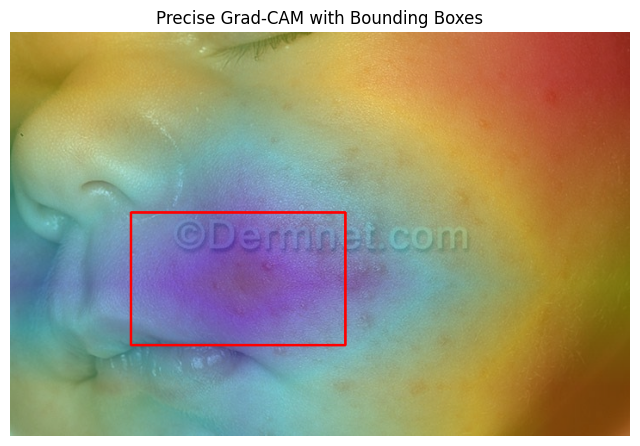

Precise Grad-CAM visualization with bounding boxes saved to ./precise_grad_cam_with_boxes.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap_with_precise_boxes(heatmap, original_image_path, output_path, threshold=0.8):
    """
    Generates a heatmap and overlays precise bounding boxes on regions with the highest activation.

    Parameters:
    - heatmap: The Grad-CAM heatmap as a numpy array.
    - original_image_path: Path to the original image.
    - output_path: Path to save the heatmap with bounding boxes.
    - threshold: Threshold for determining high-activation regions in the heatmap.
    """
    # Load the original image
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Normalize the heatmap to range [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Create the heatmap visualization
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    # Threshold the heatmap to find precise high-activation areas
    _, binary_map = cv2.threshold(heatmap_resized, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours from the binary map
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw precise bounding boxes around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < 50:  # Ignore very small boxes to avoid noise
            continue
        cv2.rectangle(superimposed_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue bounding box

    # Save and display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Precise Grad-CAM with Bounding Boxes")
    plt.savefig(output_path)
    plt.show()

# Generate Grad-CAM for a Test Image
test_image_path = "/content/drive/MyDrive/archive/train/Acne and Rosacea Photos/acne-infantile-1.jpg"
output_path = "./precise_grad_cam_with_boxes.jpg"

# Preprocess Test Image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_tensor = torch.tensor(test_img / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Forward and Grad-CAM
model.eval()
output = model(test_img_tensor)
class_idx = output.argmax(dim=1).item()
output[:, class_idx].backward()

gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model.get_activations(test_img_tensor).detach()

# Weight the channels by gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Generate Precise Heatmap with Bounding Boxes
generate_heatmap_with_precise_boxes(heatmap, test_image_path, output_path, threshold=0.8)
print(f"Precise Grad-CAM visualization with bounding boxes saved to {output_path}")


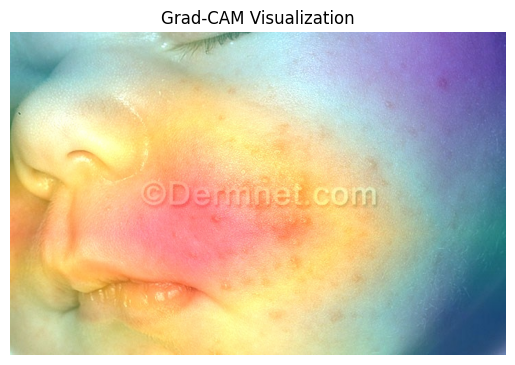

In [ ]:
# Display the image
image_path = './grad_cam_output.jpg'
image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for Matplotlib

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.title("Grad-CAM Visualization")
plt.show()

In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python